In [36]:
import csv
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding,SimpleRNN,GRU
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from string import punctuation
punct = list(punctuation)
from tqdm import tqdm
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package stopwords to C:\Users\Ahmed
[nltk_data]     Ashraf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [37]:
data=pd.read_csv('bbc-text.csv')
data.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [38]:
articles=data['text']
labels=data['category']

In [39]:
def tokenize(sentence):
    return word_tokenize(sentence)
def clean(sentence):
    words=[]
    for word in tokenize(sentence):
        if  word not in STOPWORDS and word not in punct and not word.isdigit():
            words.append(word.lower())
    return ' '.join(words)  

In [40]:
for i in tqdm(range(len(articles))):
    articles[i]=clean(articles[i])
articles.head()

  0%|          | 0/2225 [00:00<?, ?it/s]

100%|██████████| 2225/2225 [00:05<00:00, 418.08it/s]


0    tv future hands viewers home theatre systems p...
1    worldcom boss left books alone former worldcom...
2    tigers wary farrell gamble leicester say rushe...
3    yeading face newcastle fa cup premiership side...
4    ocean twelve raids box office ocean twelve cri...
Name: text, dtype: object

In [41]:
vocab_size =5000
embedding_dim =64
max_length =200
oov_tok = '<OOV>' #  Out of Vocabulary
training_portion = 0.8

In [42]:
len(labels),len(articles)

(2225, 2225)

In [43]:
labels[0],articles[0]

('tech',
 'tv future hands viewers home theatre systems plasma high-definition tvs digital video recorders moving living room way people watch tv radically different five years time according expert panel gathered annual consumer electronics show las vegas discuss new technologies impact one favourite pastimes us leading trend programmes content delivered viewers via home networks cable satellite telecoms companies broadband service providers front rooms portable devices one talked-about technologies ces digital personal video recorders dvr pvr set-top boxes like us tivo uk sky+ system allow people record store play pause forward wind tv programmes want essentially technology allows much personalised tv also built-in high-definition tv sets big business japan us slower take europe lack high-definition programming people forward wind adverts also forget abiding network channel schedules putting together a-la-carte entertainment us networks cable satellite companies worried means terms a

In [44]:
train_size = int(len(articles) * training_portion)
train_articles = articles[0: train_size]
train_labels = labels[0: train_size]
validation_articles = articles[train_size:]
validation_labels = labels[train_size:]

In [45]:
print('train_articles' ,len(train_articles))
print('train_labels', len(train_labels))
print('validation_articles', len(validation_articles))
print('validation_labels', len(validation_labels))

train_articles 1780
train_labels 1780
validation_articles 445
validation_labels 445


In [46]:
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(train_articles)
word_index = tokenizer.word_index

In [47]:
word_index

{'said': 1,
 'mr': 2,
 'would': 3,
 'year': 4,
 'also': 5,
 'people': 6,
 'new': 7,
 'us': 8,
 'one': 9,
 'could': 10,
 'last': 11,
 'first': 12,
 'time': 13,
 'two': 14,
 'government': 15,
 'world': 16,
 'uk': 17,
 'best': 18,
 'years': 19,
 'make': 20,
 'film': 21,
 'told': 22,
 'made': 23,
 'get': 24,
 'music': 25,
 'game': 26,
 'like': 27,
 'back': 28,
 'many': 29,
 'labour': 30,
 'three': 31,
 'well': 32,
 'next': 33,
 'bbc': 34,
 'take': 35,
 'set': 36,
 'number': 37,
 'added': 38,
 'way': 39,
 'market': 40,
 'company': 41,
 'may': 42,
 'says': 43,
 'election': 44,
 'home': 45,
 'party': 46,
 'good': 47,
 'going': 48,
 'much': 49,
 'work': 50,
 'still': 51,
 'win': 52,
 'show': 53,
 'think': 54,
 'games': 55,
 'go': 56,
 'top': 57,
 'second': 58,
 'million': 59,
 'england': 60,
 'firm': 61,
 'since': 62,
 'week': 63,
 'say': 64,
 'play': 65,
 'part': 66,
 '1': 67,
 'public': 68,
 'use': 69,
 'blair': 70,
 'want': 71,
 'minister': 72,
 'however': 73,
 'country': 74,
 'technology':

In [48]:
tokenizer.texts_to_sequences(['the cat sat on my table'])

[[2936, 1177, 2149]]

In [49]:
train_sequences = tokenizer.texts_to_sequences(train_articles)
len(train_sequences)

1780

In [50]:
train_padded = pad_sequences(train_sequences, maxlen=max_length)

In [51]:
len(train_padded),len(train_padded[0])

(1780, 200)

In [52]:
validation_sequences = tokenizer.texts_to_sequences(validation_articles)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length)

In [53]:
dict_={}
for i,x in tqdm(enumerate(set(labels))):
    dict_[x]=i
dict_

5it [00:00, ?it/s]


{'tech': 0, 'sport': 1, 'politics': 2, 'business': 3, 'entertainment': 4}

In [54]:
training_label_seq = np.array([dict_[train_labels[i]] for i in tqdm(range(len(train_labels)))])
validation_label_seq = np.array([dict_[np.array(validation_labels)[i]] for i in tqdm(range(len(validation_labels)))])

100%|██████████| 445/445 [00:00<00:00, 63697.54it/s]


In [55]:
train_labels[0], training_label_seq[0]

('tech', 0)

In [56]:
pd.DataFrame(training_label_seq).value_counts()

1    410
3    404
2    331
4    320
0    315
dtype: int64

In [57]:
pd.DataFrame(validation_label_seq).value_counts()

3    106
1    101
0     86
2     86
4     66
dtype: int64

Text(0, 0.5, 'Count')

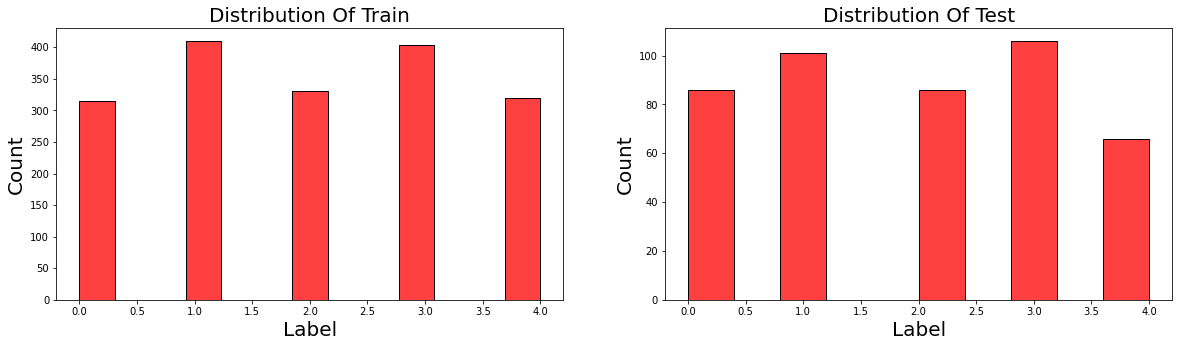

In [58]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.title("Distribution Of Train",fontsize=20)
sns.histplot(training_label_seq,color='red')
plt.xlabel('Label',fontsize=20)
plt.ylabel("Count",fontsize=20)
plt.subplot(1,2,2)
plt.title("Distribution Of Test",fontsize=20)
sns.histplot(validation_label_seq,color='red')
plt.xlabel('Label',fontsize=20)
plt.ylabel("Count",fontsize=20)

In [59]:
model = Sequential()
model.add(Embedding(vocab_size,embedding_dim))
model.add(Dropout(0.5))
model.add(GRU(units =32))
model.add(Dropout(0.5))
model.add(Dense(5,activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          320000    
                                                                 
 dropout_2 (Dropout)         (None, None, 64)          0         
                                                                 
 gru (GRU)                   (None, 32)                9408      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 165       
                                                                 
Total params: 329,573
Trainable params: 329,573
Non-trainable params: 0
_________________________________________________________________


In [60]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
early_stop=EarlyStopping(monitor='val_loss',patience=10)
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model.fit(train_padded, training_label_seq, epochs=50,
                    validation_data=(validation_padded, validation_label_seq),
                    callbacks=[reduce_lr,early_stop])

Epoch 1/50


56/56 [==============================] - 6s 63ms/step - loss: 1.6015 - accuracy: 0.2433 - val_loss: 1.5873 - val_accuracy: 0.3438 - lr: 0.0010
Epoch 2/50
56/56 [==============================] - 3s 53ms/step - loss: 1.4922 - accuracy: 0.3921 - val_loss: 1.1718 - val_accuracy: 0.4674 - lr: 0.0010
Epoch 3/50
56/56 [==============================] - 3s 56ms/step - loss: 0.9577 - accuracy: 0.6174 - val_loss: 0.7614 - val_accuracy: 0.7034 - lr: 0.0010
Epoch 4/50
56/56 [==============================] - 3s 52ms/step - loss: 0.7023 - accuracy: 0.7298 - val_loss: 0.7530 - val_accuracy: 0.7191 - lr: 0.0010
Epoch 5/50
56/56 [==============================] - 3s 53ms/step - loss: 0.5829 - accuracy: 0.7882 - val_loss: 0.6425 - val_accuracy: 0.7573 - lr: 0.0010
Epoch 6/50
56/56 [==============================] - 3s 50ms/step - loss: 0.4569 - accuracy: 0.8635 - val_loss: 0.6245 - val_accuracy: 0.7820 - lr: 0.0010
Epoch 7/50
56/56 [==============================] - 3s 51ms/step - loss: 0.3283 - accur

In [61]:
pd.DataFrame(history.history)

,loss,accuracy,val_loss,val_accuracy,lr
0,1.601489,0.243258,1.587328,0.343820,0.001000
1,1.492172,0.392135,1.171830,0.467416,0.001000
2,0.957704,0.617416,0.761419,0.703371,0.001000
3,0.702258,0.729775,0.753021,0.719101,0.001000
4,0.582860,0.788202,0.642500,0.757303,0.001000
5,0.456852,0.863483,0.624512,0.782022,0.001000
6,0.328320,0.920225,0.511571,0.806742,0.001000
7,0.208368,0.950562,0.443141,0.860674,0.001000
8,0.139333,0.973034,0.457664,0.856180,0.001000
9,0.100595,0.986517,0.399984,0.867416,0.001000


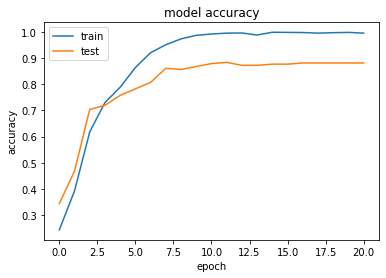

In [62]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

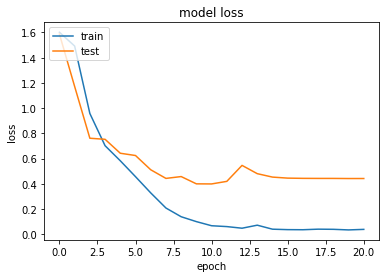

In [63]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [64]:
y_pred=model.predict(validation_padded)

14/14 [==============================] - 0s 9ms/step


In [65]:
pred=[np.argmax(i) for i in tqdm(y_pred)]
df=pd.DataFrame()
df['Prediction'],df['actual']=pred,validation_label_seq
df

100%|██████████| 445/445 [00:00<00:00, 223154.62it/s]


,Prediction,actual
0,4,4
1,2,0
2,2,2
3,1,1
4,1,1
...,...,...
440,3,3
441,2,2
442,4,4
443,2,2


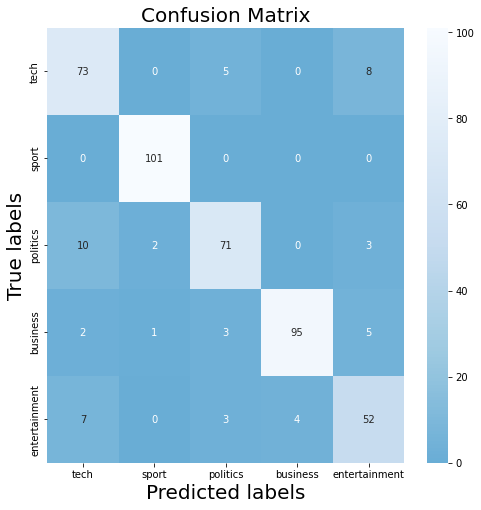

array([[ 73,   0,   5,   0,   8],
       [  0, 101,   0,   0,   0],
       [ 10,   2,  71,   0,   3],
       [  2,   1,   3,  95,   5],
       [  7,   0,   3,   4,  52]], dtype=int64)

In [66]:
CM = confusion_matrix(validation_label_seq,pred)
plt.figure(figsize=(8,8))
ax= plt.subplot()
sns.heatmap(CM, center = True, fmt='g',ax=ax,annot=True,cmap='Blues_r')
ax.set_xlabel('Predicted labels',fontsize=20)
ax.set_ylabel('True labels',fontsize=20) 
ax.set_title('Confusion Matrix',fontsize=20)
ax.xaxis.set_ticklabels(dict_.keys()) 
ax.yaxis.set_ticklabels(dict_.keys())
plt.show()
CM

In [67]:
ClassificationReport = classification_report(validation_label_seq,pred)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       0.79      0.85      0.82        86
           1       0.97      1.00      0.99       101
           2       0.87      0.83      0.85        86
           3       0.96      0.90      0.93       106
           4       0.76      0.79      0.78        66

    accuracy                           0.88       445
   macro avg       0.87      0.87      0.87       445
weighted avg       0.88      0.88      0.88       445



In [68]:
def get_code(N):
    for x,y in dict_.items():
        if y==N:
            return x

In [69]:
txt = ["blair prepares to name poll date tony blair is likely to name 5 may as election day when parliament returns from its easter break  the bbc s political editor has learned.  andrew marr says mr blair will ask the queen on 4 or 5 april to dissolve parliament at the end of that week. mr blair has so far resisted calls for him to name the day but all parties have stepped up campaigning recently. downing street would not be drawn on the claim  saying election timing was a matter for the prime minister.  a number 10 spokeswoman would only say:  he will announce an election when he wants to announce an election.  the move will signal a frantic week at westminster as the government is likely to try to get key legislation through parliament. the government needs its finance bill  covering the budget plans  to be passed before the commons closes for business at the end of the session on 7 april.  but it will also seek to push through its serious and organised crime bill and id cards bill. mr marr said on wednesday s today programme:  there s almost nobody at a senior level inside the government or in parliament itself who doesn t expect the election to be called on 4 or 5 april.  as soon as the commons is back after the short easter recess  tony blair whips up to the palace  asks the queen to dissolve parliament ... and we re going.  the labour government officially has until june 2006 to hold general election  but in recent years governments have favoured four-year terms."]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_length)
pred = model.predict(padded)
print(pred)
print(np.argmax(pred))
print(get_code(np.argmax(pred)))

1/1 [==============================] - 0s 25ms/step
[[2.6960425e-02 1.1699176e-03 9.7067225e-01 2.8043609e-05 1.1693159e-03]]
2
politics


In [70]:
txt = ["call to save manufacturing jobs the trades union congress (tuc) is calling on the government to stem job losses in manufacturing firms by reviewing the help it gives companies.  the tuc said in its submission before the budget that action is needed because of 105 000 jobs lost from the sector over the last year. it calls for better pensions  child care provision and decent wages. the 36-page submission also urges the government to examine support other european countries provide to industry. tuc general secretary brendan barber called for  a commitment to policies that will make a real difference to the lives of working people.    greater investment in childcare strategies and the people delivering that childcare will increases the options available to working parents   he said.  a commitment to our public services and manufacturing sector ensures that we can continue to compete on a global level and deliver the frontline services that this country needs.  he also called for  practical measures  to help pensioners  especially women who he said  are most likely to retire in poverty . the submission also calls for decent wages and training for people working in the manufacturing sector."]

seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_length)
pred = model.predict(padded)
print(pred)
print(np.argmax(pred))
print(get_code(np.argmax(pred)))

1/1 [==============================] - 0s 24ms/step
[[8.1708407e-05 9.3812280e-04 3.0482756e-06 9.8944539e-01 9.5317466e-03]]
3
business
